In [78]:
from utils import *
from environnement import Environnement
from policies import Policy,RandomPolicy,SmarterRandomPolicy
from tester import Tester
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

In [79]:
env_params = {
    'experiment_length':1000, # Beaucoup de jours
    "n_users":5, #peu d'utilisateur
    "n_clusters":2, # peu de vélos
    'dim':5,
    "n_bikes_per_user":1, # Un seul vélo proposé à chaque fois
    "users_per_day":1,
    'bike_overlapping':False
}
env = Environnement(env_params,2)
policies = [RandomPolicy({"list_length":5,"price":i},3) for i in [100,500,1000,2000]]
policies = [RandomPolicy({"list_length":1,"price":500},3),SmarterRandomPolicy({"list_length":5,"price":500},3)]

In [80]:
class EGreedyPolicy(Policy):
    """
    Example de policy qui fait un epsilon greedy (mais qui marche pas trop trop)
    
    """
    
    
    def __init__(self,params,seed):
        self.params = params
        self.seed = seed
        self.list_length = self.params["list_length"]
        self.n_bikes = self.params["n_bikes"]
        self.init()
        self.eps = self.params["eps"]
        self.__name__ = f"EGreedyPolicy_{params['price']}"
        

            
        
    def get_action(self,context):
        
        df = self.get_history() # La méthode pour récupérer l'historique
        
        df = df[df.user_id == context['user_id']]
        
        if self.rng.uniform() < self.eps or len(df) < 10:
        
            a = [len(d) for d in context["bikes_availability"]]

            chosen_index = self.rng.randint(0,len(a))  

            return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]
        
        
        else:
            bikes_ids = pd.DataFrame({
                'bike_id':context["bikes_available"]
            })
            
            
            df = df.merge(bikes_ids,on='bike_id').groupby('bike_id').accepted.mean().reset_index().sort_values('accepted',ascending=True)
            
            chosen_index = context["bikes_available"].index(df.bike_id.values[0])
            
            return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]
            

In [81]:
class UCBPolicy(Policy):
    """
    Exemple de UCB policy
    
    """
    
    
    def __init__(self,params,seed):
        self.params = params
        self.seed = seed
        self.list_length = self.params["list_length"]
        self.n_bikes = self.params["n_bikes"]
        self.init()
        self.__name__ = f"UCBPolicy_{params['price']}"
        
        
        
    def get_action(self,context):
        
        df = self.get_history() 
        
        #on veut s'assurer que les Nt(a) ne valent pas 0 donc on doit attribuer chaque vélo au moins une fois
        if df.shape[0]<self.params["n_bikes"]:
            return [context["bikes_available"][df.shape[0]]],[context['bikes_availability'][df.shape[0]]],[self.params["price"]]
        
        else :

            df = df[df.user_id == context['user_id']]

            if len(df) < 10:
                a = [len(d) for d in context["bikes_availability"]]
                chosen_index = self.rng.randint(0,len(a))  
                return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]
            
            else :
                
                #bikes_ids a une seule colonne 'bike_id' qui contient les id des bikes
                bikes_ids = pd.DataFrame({
                        'bike_id':context["bikes_available"]
                    })

                df = df.merge(bikes_ids,on='bike_id').groupby('bike_id').accepted.mean().reset_index().sort_values('accepted',ascending=True)

                #crée la colonne contenant le Nt(a) du dénominateur dans ucb
                df2 = self.get_history()[self.get_history().user_id == context['user_id']].groupby('bike_id').accepted.sum().reset_index()
                df2.columns=['bike_id','sum_accepted']

                df = df.merge(df2,on='bike_id')

                #on suppose c=1
                df['arg_ucb']=df.apply(lambda x : (x['accepted'] + np.sqrt(context['day']/x['sum_accepted'])),axis=1)

                df=df.reset_index().sort_values(by=['arg_ucb'],ascending=False)

                chosen_index = context["bikes_available"].index(df.bike_id.values[0])

                return [context["bikes_available"][chosen_index]],[context['bikes_availability'][chosen_index]],[self.params["price"]]

In [82]:
params = {
    'n_steps':800,
    "n_rep":5
}

In [83]:
tester = Tester([
    EGreedyPolicy({"list_length":1,"price":10,"n_bikes":2,"eps":0.5},3),
    EGreedyPolicy({"list_length":1,"price":50,"n_bikes":2,"eps":0.5},3),
],env,params)

In [84]:
tester2 = Tester([
    UCBPolicy({"list_length":1,"price":10,"n_bikes":2,"eps":0.5},3),
],env,params)

In [85]:
tester2.run()







  0%|          | 0/5 [00:00<?, ?it/s]

Testing policy |UCBPolicy_10|








 20%|██        | 1/5 [00:18<01:15, 18.95s/it]





 40%|████      | 2/5 [00:37<00:56, 18.89s/it]/home/coralie/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in double_scalars






 60%|██████    | 3/5 [00:56<00:37, 18.77s/it]





 80%|████████  | 4/5 [01:14<00:18, 18.71s/it]





100%|██████████| 5/5 [01:32<00:00, 18.51s/it]







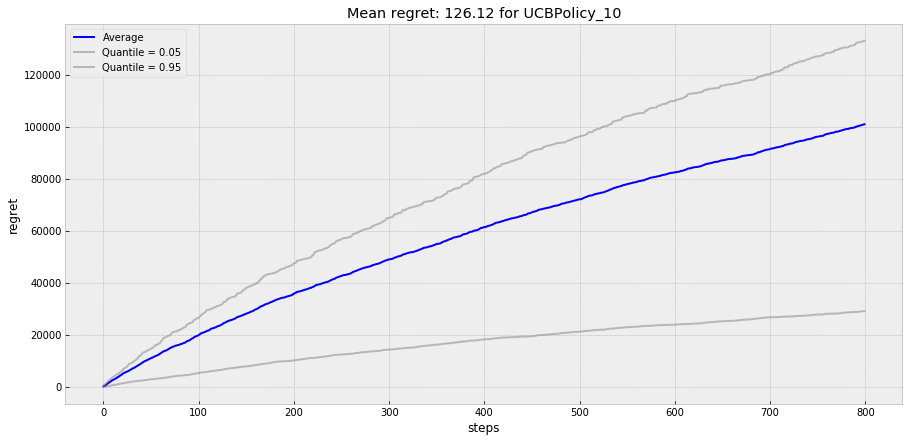

In [86]:
tester2.plotAllPoliciesQuantiles()

In [8]:
tester.run()

  0%|          | 0/5 [00:00<?, ?it/s]

Testing policy |EGreedyPolicy_10|


  0%|          | 0/5 [00:00<?, ?it/s]

Testing policy |EGreedyPolicy_50|


100%|██████████| 5/5 [00:46<00:00,  9.20s/it]


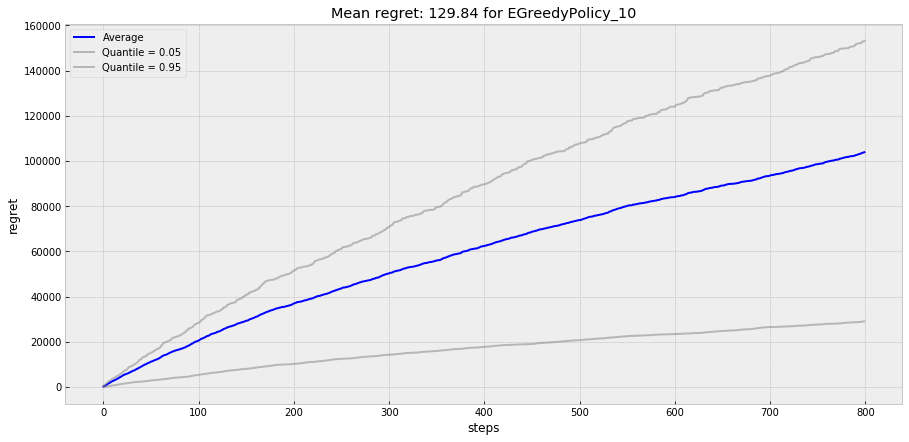

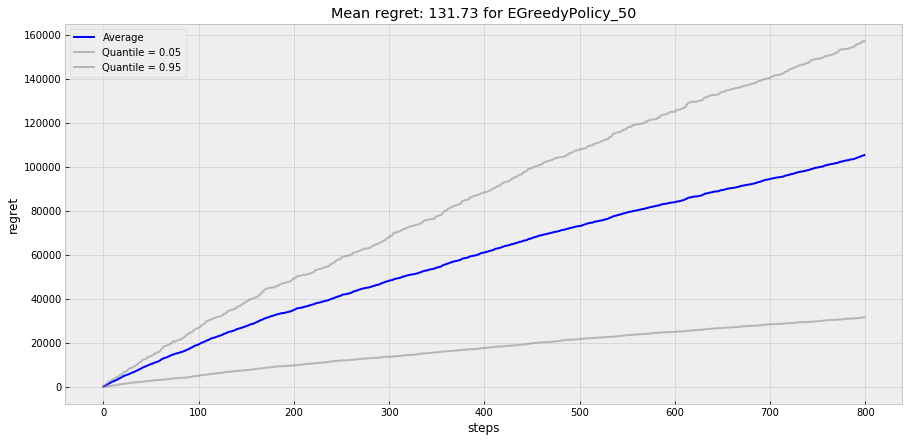

In [9]:
tester.plotAllPoliciesQuantiles()

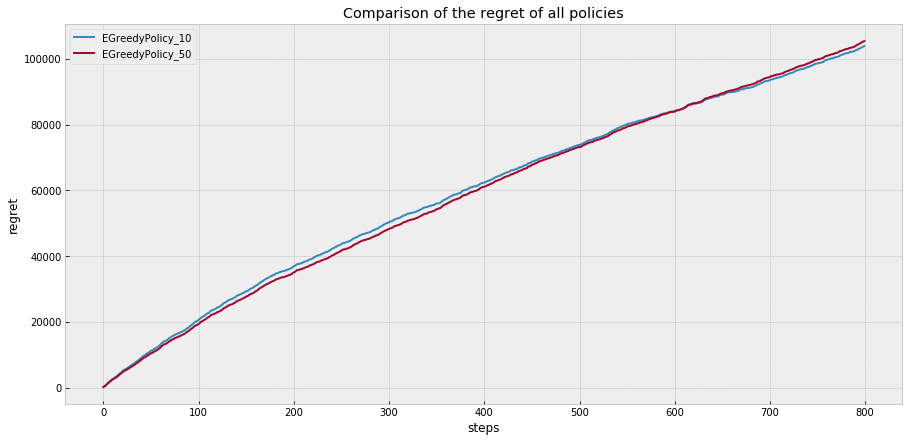

In [10]:
tester.plotAllPoliciesCompared()

In [11]:
dfs = tester.history["EGreedyPolicy_10"]

In [12]:
dfs[0]

,user_id,days_wanted,bike_proposed,price_proposed,days_proposed,answer,reward,best_reward
0,0,"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20...",[1],[10],"[[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2...",1,10,522.794065
0,0,[],[0],[10],[[]],0,10,522.794065
0,3,[63],[1],[10],[[63]],REFUSED,0,159.818249
0,0,"[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]",[1],[10],"[[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, ...",1,10,522.794065
0,3,"[14, 15, 16, 17, 18, 19, 20, 21, 22]",[0],[10],"[[14, 15, 16, 17, 18, 19, 20, 21, 22]]",0,10,159.818249
0,0,"[17, 18, 19, 20, 21, 22]",[0],[10],"[[17, 18, 19, 20, 21, 22]]",0,10,522.794065
0,0,"[14, 15, 16, 17]",[0],[10],"[[14, 15, 16, 17]]",0,10,522.794065
0,3,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]",[0],[10],"[[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]",REFUSED,0,159.818249
0,4,[],[1],[10],[[]],REFUSED,0,86.986469
0,0,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...",[0],[10],"[[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...",0,10,522.794065
